In [2]:
import torch
import matplotlib.pyplot as plt
import os
import numpy as np
import copy
os.environ["KMP_DUPLICSCORE_LIB_OK"]="TRUE"

In [5]:
results = torch.load('linear_model_results_withT.pt')

In [6]:
results

[{'seed': 0,
  'names': ['ML-N',
   'ML-L',
   'ML-T',
   'URR-N',
   'URR-L',
   'URR-T',
   'CMMD-V',
   'CMMD-U',
   'True'],
  'Coeffs': tensor([[[0.9845],
           [0.9998],
           [1.0021],
           [0.9779],
           [0.9707],
           [1.0040],
           [0.9528],
           [0.9268],
           [1.0000]]]),
  'dist': 'normal',
  'nsamples': 1000},
 {'seed': 0,
  'names': ['ML-N',
   'ML-L',
   'ML-T',
   'URR-N',
   'URR-L',
   'URR-T',
   'CMMD-V',
   'CMMD-U',
   'True'],
  'Coeffs': tensor([[[1.0393],
           [1.0075],
           [1.0111],
           [1.0214],
           [0.9871],
           [0.9083],
           [0.9902],
           [0.9809],
           [1.0000]]]),
  'dist': 'gamma',
  'nsamples': 1000},
 {'seed': 0,
  'names': ['ML-N',
   'ML-L',
   'ML-T',
   'URR-N',
   'URR-L',
   'URR-T',
   'CMMD-V',
   'CMMD-U',
   'True'],
  'Coeffs': tensor([[[1.1005],
           [1.0567],
           [0.8987],
           [1.0405],
           [0.9728],
           [0

In [7]:
nmodel = len(results[0]['names'])
ndist = 5
nsamples = 1
nseed = 50

In [8]:
MAE = torch.zeros((nsamples,nmodel,ndist,nseed))

t = 0
for s in range(nseed):
    for n in range(nsamples):
        for d in range(ndist):
            MAE[n,:,d,s] = (results[t]['Coeffs'] - results[t]['Coeffs'][...,0][...,-1]).abs().view((nmodel,))
            t += 1

In [9]:
from collections import defaultdict
import numpy as np

def print_cf_rmse_latex(results_list):
    data = defaultdict(lambda: defaultdict(list))
    
    # Get ordering from first result
    first_result = results_list[0]
    all_methods = [name for name in first_result["names"] if name not in ["True", "HSIC"]]
    all_dists = []
    
    for result in results_list:
        dist = result["dist"]
        if dist not in all_dists:
            all_dists.append(dist)

        coeffs = result["Coeffs"].squeeze(0)  # (n_methods, 1)
        names = result["names"]
        true_val = coeffs[names.index("True")].item()

        for i, name in enumerate(names):
            if name in ["True", "HSIC"]:
                continue
            est_val = coeffs[i].item()
            rmse = (est_val - true_val) ** 2
            data[name][dist].append(rmse)

    print("\\begin{tabular}{l" + "c" * len(all_dists) + "}")
    print("\\toprule")
    print("Method & " + " & ".join(all_dists) + " \\\\")
    print("\\midrule")
    
    for method in all_methods:
        row = [method]
        for dist in all_dists:
            vals = data[method].get(dist, [])
            if vals:
                mean = np.sqrt(np.mean(vals))
                se = np.sqrt(np.var(vals, ddof=1) / len(vals)) if len(vals) > 1 else 0.0
                row.append(f"${mean:.3f} \\pm {se:.3f}$")
            else:
                row.append("N/A")
        print(" & ".join(row) + " \\\\")
    
    print("\\bottomrule")
    print("\\end{tabular}")
print_cf_rmse_latex(results)

\begin{tabular}{lccccc}
\toprule
Method & normal & gamma & cauchy & inversegamma & rademacher \\
\midrule
ML-N & $0.042 \pm 0.000$ & $0.039 \pm 0.000$ & $2.035 \pm 2.131$ & $3.203 \pm 2.809$ & $0.035 \pm 0.000$ \\
ML-L & $0.051 \pm 0.001$ & $0.036 \pm 0.000$ & $0.049 \pm 0.000$ & $0.074 \pm 0.001$ & $0.188 \pm 0.009$ \\
ML-T & $0.032 \pm 0.000$ & $0.031 \pm 0.000$ & $3.090 \pm 7.358$ & $6.058 \pm 8.847$ & $0.028 \pm 0.000$ \\
URR-N & $0.047 \pm 0.000$ & $0.031 \pm 0.000$ & $0.050 \pm 0.000$ & $0.044 \pm 0.000$ & $0.062 \pm 0.001$ \\
URR-L & $0.044 \pm 0.000$ & $0.029 \pm 0.000$ & $0.045 \pm 0.000$ & $0.045 \pm 0.000$ & $0.081 \pm 0.001$ \\
URR-T & $0.039 \pm 0.000$ & $0.115 \pm 0.001$ & $0.045 \pm 0.000$ & $0.689 \pm 0.008$ & $0.053 \pm 0.000$ \\
CMMD-V & $0.046 \pm 0.001$ & $0.032 \pm 0.000$ & $0.049 \pm 0.001$ & $0.038 \pm 0.000$ & $0.018 \pm 0.000$ \\
CMMD-U & $0.047 \pm 0.000$ & $0.028 \pm 0.000$ & $0.053 \pm 0.001$ & $0.036 \pm 0.000$ & $0.018 \pm 0.000$ \\
\bottomrule
\end{tabula

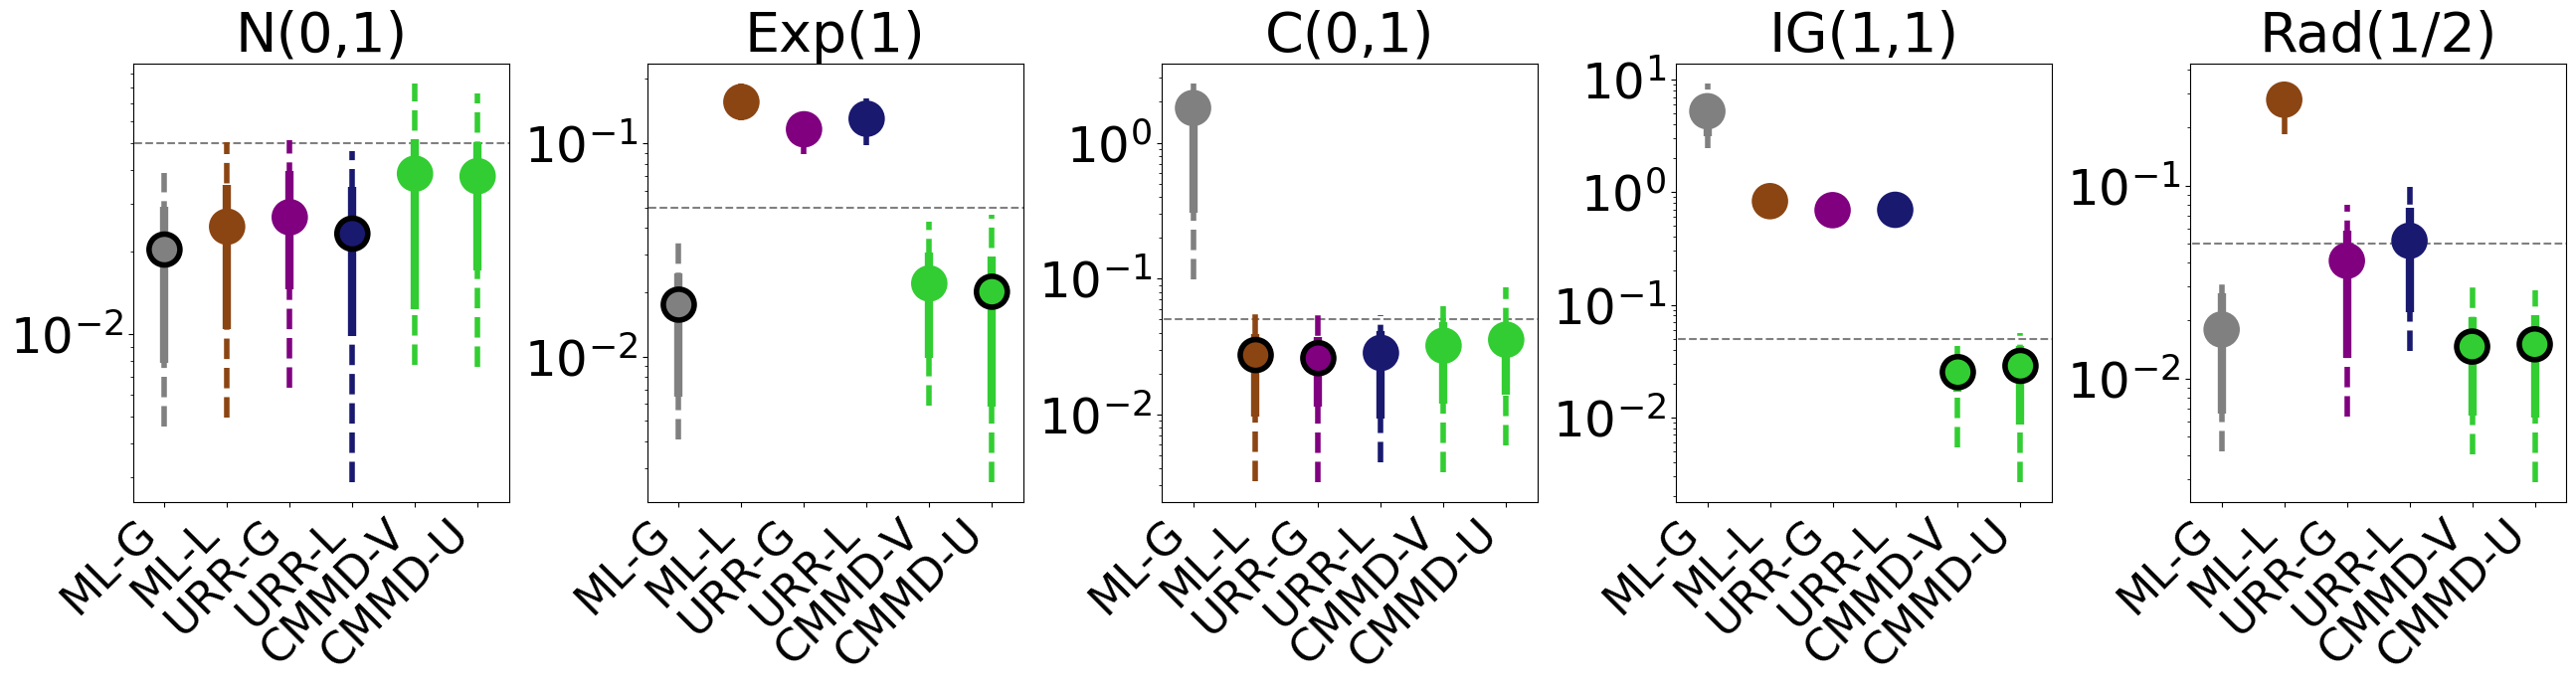

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import copy
from matplotlib.ticker import FormatStrFormatter
from matplotlib import rcParams, rc_file_defaults

# Configuration (doubled font sizes)
ylabelsize = 36   # was 18
xlabelsize = 32   # was 16
rc_file_defaults()
rcParams['xtick.labelsize'] = xlabelsize
rcParams['ytick.labelsize'] = ylabelsize 

# Parameters (Replace with actual data)

model_select = [0, 1, 3, 4, 5, 6]
sample_select = [0]
dist_select = [0, 1, 2, 3, 4]
Dataset_names = [r"N=1000"]
Dist_names = ["N(0,1)", r"Exp(1)", r"C(0,1)", r"IG(1,1)", "Rad(1/2)"]
Colours = ["gray", "saddlebrown", "purple", "midnightblue", "limegreen", "limegreen"]
quantiles = [0.75, 0.9, 0.9]
linestyles = ["-", "--", "--"]

# Double line widths: original lws = [3, 2, 2] become:
lws = [6, 4, 4]

# Simulated Results for Testing (Replace with your real data)
#Model_names = [results[0]['names'][i] for i in model_select]
Model_names = [
    "ML-G", "ML-L", "URR-G", "URR-L", 
    "CMMD-V", "CMMD-U"
]
# Prepare colors for scatter points
colours_best = Colours

# Create the figure (doubled figure size from (13,7) to (26,14))
fig, axs = plt.subplots(nrows=len(sample_select), ncols=5, figsize=(26, 7))

# Loop through rows and columns of the grid
for i in range(len(sample_select)):
    for k in range(5):  # 5 distributions
        axs[k].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        axs[k].set_xticks(range(1, len(model_select) + 1))
        axs[k].set_xlim(0.5, len(model_select) + 0.5)
        #axs[i, k].set_yscale("log")
        
        # Extract mean and percentiles for the current sample and distribution
        means = MAE[sample_select[i], model_select, dist_select[k]].mean(-1).numpy()
        if k == 0:
            #axs[k].set_ylabel(Dataset_names[i], fontsize=40)  # was 20
            axs[k].set_yticks(np.linspace(0, 0.5, 6))  # Adjust y-ticks
        else:
            axs[k].set_yticklabels([])

        if i == 0:
            axs[k].set_title(Dist_names[k], fontsize=40)  # was 20

        # Diagonal x-axis labels for models
        axs[k].set_xticklabels(Model_names, rotation=45, ha='right')

        # Highlight best-performing models
        cols_best = copy.deepcopy(colours_best)
        sorted_means = np.sort(means)
        best_two = [np.where(means == sorted_means[j])[0][0] for j in range(2)]
        for c in range(len(best_two)):
            cols_best[best_two[c]] = "black"

        # Scatter plot of means (marker size doubled: 150 -> 300, linewidth doubled: 2 -> 4)
        axs[k].scatter(range(1, len(model_select) + 1), means, color=Colours, s=500, 
                          zorder=12, edgecolors=cols_best, lw=4)

        # Plot percentile bars (line widths doubled via lws)
        for j in range(2):
            upper = np.quantile(MAE[sample_select[i], model_select, dist_select[k]].numpy(), quantiles[j], axis=-1)
            lower = np.quantile(MAE[sample_select[i], model_select, dist_select[k]].numpy(), 1 - quantiles[j], axis=-1)
            axs[k].vlines(range(1, len(model_select) + 1), lower, upper, color=Colours, 
                             linestyle=linestyles[j], lw=lws[j], zorder=10 - 3 * j)
        
        # Dashed threshold lines (optional)
        threshold = 0.05
        axs[k].hlines(threshold, 0, len(model_select) + 1, color="grey", linestyle="dashed")

        # Adjust y-axis limits
        axs[k].set_yscale("log", base = 10)
        #axs[k].set_ylim(1e-3, 10)
        #axs[k].grid(True)

# Adjust layout and save the plot
fig.tight_layout()
fig.savefig("linear_model_plot_n=1000", bbox_inches="tight")
plt.show()

ValueError: The number of FixedLocator locations (6), usually from a call to set_ticks, does not match the number of labels (7).

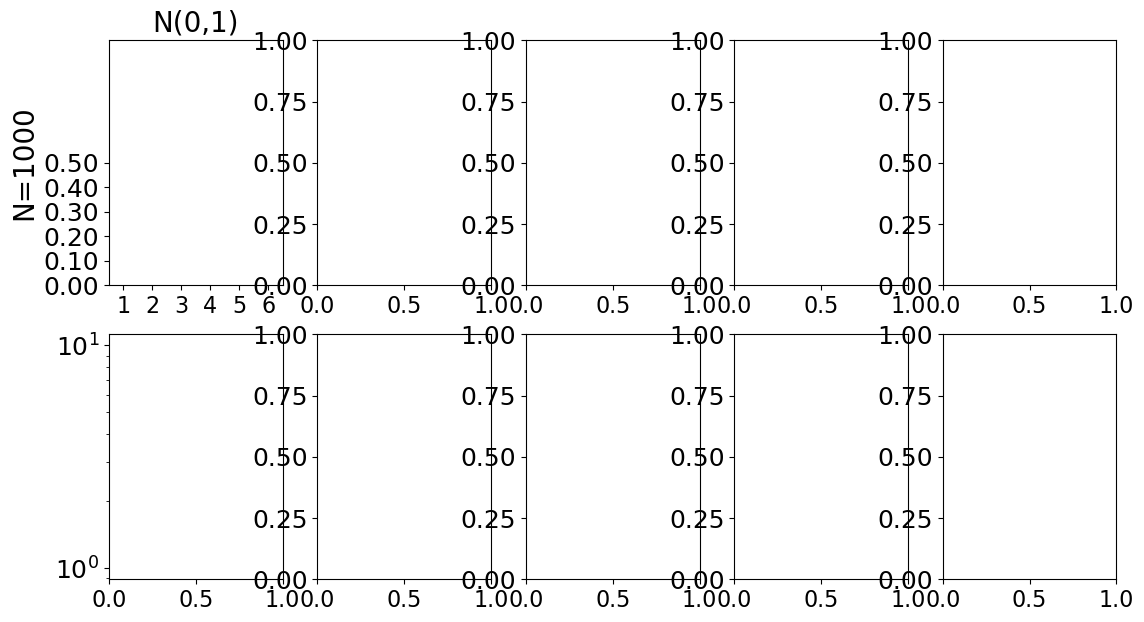

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import copy
from matplotlib.ticker import FormatStrFormatter
from matplotlib import rcParams, rc_file_defaults

# Configuration
ylabelsize = 18
xlabelsize = 16
rc_file_defaults()
rcParams['xtick.labelsize'] = xlabelsize
rcParams['ytick.labelsize'] = ylabelsize 

# Parameters (Replace with actual data)
model_select = [0, 1, 2, 3, 4, 5]
sample_select = [0, 0]
Dataset_names = [r"N=1000", "N=1000"]
Dist_names = ["N(0,1)", r"Exp(1)", r"C(0,1)", r"IG(1,1)", "Rad(1/2)"]
Colours = ["gray", "saddlebrown", "purple", "midnightblue", "limegreen", "limegreen"]
quantiles = [0.75, 0.95, 0.9]
linestyles = ["-", "--", "--"]
lws = [3, 2, 2]

# Simulated Results for Testing (Replace with your real data)
Model_names = results[0]['names'][:-1]

# Prepare colors for scatter points
colours_best = Colours

# Create the figure
fig, axs = plt.subplots(nrows=len(sample_select), ncols=5, figsize=(13, 7))

# Loop through rows and columns of the grid
for i in range(len(sample_select)):
    for k in range(5):  # 5 distributions
        axs[i, k].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        axs[i, k].set_xticks(range(1, len(model_select) + 1))
        axs[i, k].set_xlim(0.5, len(model_select) + 0.5)
        axs[1, k].set_yscale("log")
        
        # Extract mean and percentiles for the current sample and distribution
        means = MAE[sample_select[i], model_select, k].mean(-1).numpy()
        if k == 0:
            axs[i, k].set_ylabel(Dataset_names[i], fontsize=20)
            if i ==0:
                axs[i, k].set_yticks(np.linspace(0, 0.5, 6))  # Adjust y-ticks
        else:
            if i ==0:
                axs[i, k].set_yticklabels([])

        if i == 0:
            axs[i, k].set_title(Dist_names[k], fontsize=20)

        # Diagonal x-axis labels for models
        axs[i, k].set_xticklabels(Model_names, rotation=45, ha='right')

        # Highlight best-performing models
        cols_best = copy.deepcopy(colours_best)
        sorted_means = np.sort(means)
        best_two = [np.where(means == sorted_means[j])[0][0] for j in range(2)]
        for c in range(len(best_two)):
            cols_best[best_two[c]] = "black"

        # Scatter plot of means
        axs[i, k].scatter(range(1, len(model_select) + 1), means, color=Colours, s=150, zorder=12, 
                          edgecolors=cols_best, lw=2)

        # Plot percentile bars
        for j in range(2):
            upper = np.quantile(MAE[sample_select[i], model_select, k].numpy(), quantiles[j], axis=-1)
            lower = np.quantile(MAE[sample_select[i], model_select, k].numpy(), 1 - quantiles[j], axis=-1)
            axs[i, k].vlines(range(1, len(model_select) + 1), lower, upper, color=Colours, 
                             linestyle=linestyles[j], lw=lws[j], zorder=10 - 3 * j)
        
        # Dashed threshold lines (optional)
        threshold = 0.1 if sample_select[i] == 0 else 0.05
        axs[i, k].hlines(threshold, 0, len(model_select) + 1, color="grey", linestyle="dashed")

        # Adjust y-axis limits
        if i ==0:
            axs[i, k].set_ylim(-0.05,0.4)
        #axs[i, 0].set_ylim(1e-2, 10)

# Adjust layout and save the plot
fig.tight_layout()
fig.savefig("Reg_experiments_violin_plot_rotated", bbox_inches="tight")
plt.show()

/tmp/ipykernel_3527934/2211010741.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


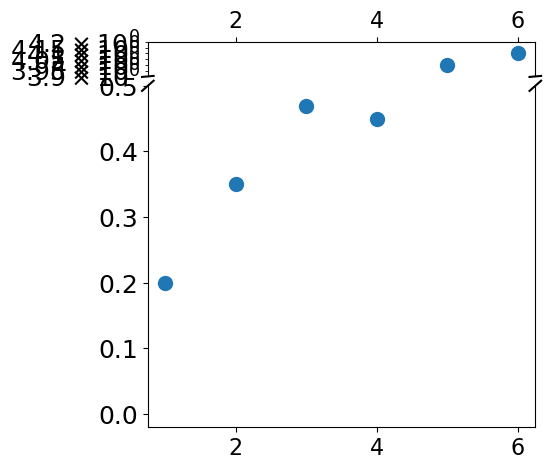

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Example data:
x = np.arange(1, 7)
y = np.array([0.2, 0.35, 0.47, 0.45, 4.0, 4.1])

fig = plt.figure(figsize=(5,5))

# Create two subplots, stacked vertically, sharing the same x-axis
# We'll keep a small vertical space (hspace)
gs = fig.add_gridspec(nrows=2, height_ratios=[1, 10], hspace=0.05)
ax_top = fig.add_subplot(gs[0])
ax_bottom = fig.add_subplot(gs[1], sharex=ax_top)

#----------------------------
# Bottom axis: show [0, 0.5]
#----------------------------
ax_bottom.scatter(x, y, s=100)
ax_bottom.set_ylim(-0.02, 0.5)  # same as your original lower range

# We'll hide the upper spines of ax_bottom to prepare for the break mark
ax_bottom.spines['top'].set_visible(False)
ax_bottom.xaxis.tick_bottom()
ax_bottom.tick_params(labeltop=False)  # no top labels

#----------------------------
# Top axis: show [3.9, 4.2]
#----------------------------
#ax_top.set_yscale("log")
ax_top.scatter(x, y, s=100)
ax_top.set_ylim(3.9, 4.2)  # adjust as needed around the "worst" mean
ax_top.spines['bottom'].set_visible(False)
ax_top.xaxis.tick_top()
ax_top.tick_params(labelbottom=False)  # no bottom labels

#----------------------------
# Draw diagonal lines to show the break in the axis
#----------------------------
d = .015  # diagonal line size, can tweak

# Diagonal lines in the top axis's lower-left corner
ax_top.plot(
    (-d, +d), (-d, +d),
    transform=ax_top.transAxes, color='k', clip_on=False
)
ax_top.plot(
    (1 - d, 1 + d), (-d, +d),
    transform=ax_top.transAxes, color='k', clip_on=False
)

# Diagonal lines in the bottom axis's upper-left corner
ax_bottom.plot(
    (-d, +d), (1 - d, 1 + d),
    transform=ax_bottom.transAxes, color='k', clip_on=False
)
ax_bottom.plot(
    (1 - d, 1 + d), (1 - d, 1 + d),
    transform=ax_bottom.transAxes, color='k', clip_on=False
)

# Finally, show
plt.tight_layout()
plt.show()

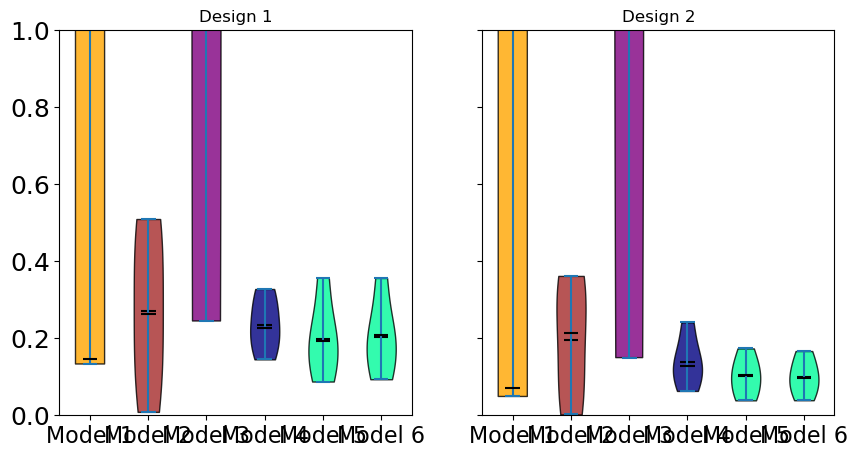

In [44]:
Data = MAE.max(3)[0]  # Shape (N, M, T) where M=6

# Parameters
N, M, T = Data.shape
Colours = ["orange", "brown", "purple", "navy", "mediumspringgreen", "mediumspringgreen"]

# Use only M-1 models (exclude the last one)
Data = Data[:, :-1, :]  # New shape (N, M-1, T)
Colours = Colours       # Exclude the color for the last model
M -= 1                        # Update M to reflect the new count

# Create a figure for the violin plots
fig, axes = plt.subplots(1, N, figsize=(N * 5, 5), sharey=True)

# Ensure axes is iterable even for a single subplot
if N == 1:
    axes = [axes]

# Generate a violin plot for each experiment design (N = 2)
for i in range(N):
    ax = axes[i]
    data = [Data[i, j, :] for j in range(M)]  # Extract data for each model
    parts = ax.violinplot(data, showmeans=True, showmedians=True)
    
    # Customize the colors of each violin
    for j, pc in enumerate(parts['bodies']):
        pc.set_facecolor(Colours[j])
        pc.set_edgecolor('black')
        pc.set_alpha(0.8)
    
    # Customize mean and median lines
    for key in ['cmeans', 'cmedians']:
        if key in parts:
            parts[key].set_color('black')

    # Add labels and titles
    ax.set_title(f'Design {i+1}')
    ax.set_xticks(range(1, M + 1))
    ax.set_xticklabels([f'Model {j+1}' for j in range(M)])
    ax.set_ylim(0,1)